In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2007-01-01'
END = '2023-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

In [5]:
stk_info

secID    ticker secShortName cnSpell exchangeCD assetClass  \
0        000001.XSHE    000001         平安银行    PAYH       XSHE          E   
1        000002.XSHE    000002          万科A     WKA       XSHE          E   
2        000003.XSHE    000003        PT金田A   PTJTA       XSHE          E   
3        000004.XSHE    000004         ST国华    STGH       XSHE          E   
4        000005.XSHE    000005         ST星源    STXY       XSHE          E   
5        000006.XSHE    000006         深振业A    SZYA       XSHE          E   
6        000007.XSHE    000007          全新好     QXH       XSHE          E   
7        000008.XSHE    000008         神州高铁    SZGT       XSHE          E   
...              ...       ...          ...     ...        ...        ...   
25337    900950.XSHG    900950         新城B股    XCBG       XSHG          E   
25338    900951.XSHG    900951         退市大化    TSDH       XSHG          E   
25339    900952.XSHG    900952         锦港B股    JGBG       XSHG          E   
25340    900953.XSHG    900953          凯马B     KMB       XSHG          E   
25341    900955.XSHG    900955         退市海B    TSHB       XSHG          E   
25342    900956.XSHG    900956         东贝B股    DBBG       XSHG          E   
25343    900957.XSHG    900957         凌云B股    LYBG       XSHG          E   
29902  DY600018.XSHG  DY600018         上港集箱    SGJX       XSHG          E   

      listStatusCD    listDate transCurrCD          ISIN  partyID  delistDate  
0                L  1991-04-03         CNY  CNE000000040      2.0         NaN  
1                L  1991-01-29         CNY  CNE0000000T2      3.0         NaN  
2               DE  1991-07-03         CNY  CNE1000031Y5      4.0  2002-06-14  
3                L  1991-01-14         CNY  CNE0000000Y2      5.0         NaN  
4                L  1990-12-10         CNY  CNE0000001L7      6.0         NaN  
5                L  1992-04-27         CNY  CNE000000164      7.0         NaN  
6                L  1992-04-13         CNY  CNE0000000P0      8.0         NaN  
7                L  1992-05-07         CNY  CNE0000001C6      9.0         NaN  
...            ...         ...         ...           ...      ...         ...  
25337           DE  1997-10-16         USD  CNE000000TH1   1429.0  2015-11-23  
25338           DE  1997-10-21         USD  CNE000000TJ7   1430.0  2020-08-27  
25339            L  1998-05-19         USD  CNE000000W88    763.0         NaN  
25340            L  1998-06-24         USD  CNE000000WP8   1431.0         NaN  
25341           DE  1999-01-18         USD  CNE000000YC2   1063.0  2022-07-13  
25342           DE  1999-07-15         USD  CNE000000ZS5   1432.0  2020-11-23  
25343            L  2000-07-28         USD  CNE0000013W9   1433.0         NaN  
29902           DE  2000-07-19         CNY           NaN    618.0  2006-10-20  

[5244 rows x 12 columns]

## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [7]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [8]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2007-01  0.002100
1    2007-02  0.002110
2    2007-03  0.002234
3    2007-04  0.002125
4    2007-05  0.002527
5    2007-06  0.002542
6    2007-07  0.002481
7    2007-08  0.002404
..       ...       ...
187  2022-08  0.001251
188  2022-09  0.001426
189  2022-10  0.001400
190  2022-11  0.001596
191  2022-12  0.001955
192  2023-01  0.001856
193  2023-02  0.001910
194  2023-03  0.001970

[195 rows x 2 columns]

## Beta

In [9]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
554352  689009.XSHG  2022-07  0.7987
554353  689009.XSHG  2022-08  0.8589
554354  689009.XSHG  2022-09  0.9106
554355  689009.XSHG  2022-10  0.7083
554356  689009.XSHG  2022-11  0.7363
554357  689009.XSHG  2022-12  0.6919
554358  689009.XSHG  2023-01  0.7379
554359  689009.XSHG  2023-02  0.7453

[554360 rows x 3 columns]

## Trading data

In [10]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)
# Monthly
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()

(11600428, 5)
(11048078, 5)


In [11]:
stk_df_m

secID       ym  tradeDate  closePrice  negMarketValue
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10
1       000001.XSHE  2007-07 2007-07-31    1146.498    5.616330e+10
2       000001.XSHE  2007-08 2007-08-31    1202.510    5.890714e+10
3       000001.XSHE  2007-09 2007-09-28    1265.167    6.197651e+10
4       000001.XSHE  2007-10 2007-10-31    1520.542    7.448652e+10
5       000001.XSHE  2007-11 2007-11-30    1141.751    5.593078e+10
6       000001.XSHE  2007-12 2007-12-28    1221.497    6.574629e+10
7       000001.XSHE  2008-01 2008-01-31    1053.778    5.850212e+10
...             ...      ...        ...         ...             ...
552750  900957.XSHG  2022-08 2022-08-31       0.644    1.175760e+08
552751  900957.XSHG  2022-09 2022-09-30       0.592    1.080080e+08
552752  900957.XSHG  2022-10 2022-10-31       0.603    1.100320e+08
552753  900957.XSHG  2022-11 2022-11-30       0.617    1.126080e+08
552754  900957.XSHG  2022-12 2022-12-30       0.568    1.037760e+08
552755  900957.XSHG  2023-01 2023-01-31       0.590    1.076400e+08
552756  900957.XSHG  2023-02 2023-02-28       0.578    1.054320e+08
552757  900957.XSHG  2023-03 2023-03-03       0.568    1.037760e+08

[552758 rows x 5 columns]

In [13]:
pd.__version__

'0.24.2'

## Momentum

Momentum 介绍：

Momentum即动量，指的是过去一段时间表现较好的股票，在未来一段时间内也会较好。“过去”和“未来”有很多定义，比较常见的：
- 过去：t月前的t-12:t-2个月的累积收益率
- 未来: t月的收益

也即，中间跳过了一个月，t-1。
这是因为，短期发现了反转，reversal：上个月表现好的，这个月表现差

Momentum 的计算涉及到pandas groupby rolling。如果是自定义的函数，apply会比较慢。但新版本(pandas version >= 1)中，apply中可以指定用numba作为计算引擎，速度会快非常多。由于优矿的pandas版本很低, 没有这个选项。

另外，按照月来做rolling时，pandas rolling的选项不可以用"MonthEnd"这样长度不固定的时间作为window size。因此，如果想做得很精确的话，需要用一些其他的办法。一种比较容易的思路是把停牌的日期(用MultiIndex)填上，对应的ret值留空。窗口长度就可以固定（通过指定observation个数，而不是月份数）。

- 注意：应当先计算收益率，再填充空值。原因：
    - 如果先填充空值，刚恢复交易时的第一个月，ret会是NaN。若用0填充来得到1+ret==1，会有一定程度的失真。
    - 先计算ret，则刚恢复交易时的第一个月，ret是从刚停牌时的价格和这个月的价格相除计算得到的，较真实。
    
例：

In [15]:
stk_df.loc[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-20') & (stk_df['tradeDate']<='2010-07-10')]

secID  tradeDate closePrice negMarketValue       ym
842  000001.XSHE 2010-06-21    755.071    5.35113e+10  2010-06
843  000001.XSHE 2010-06-22    764.561    5.41838e+10  2010-06
844  000001.XSHE 2010-06-23    757.134    5.36575e+10  2010-06
845  000001.XSHE 2010-06-24    764.561    5.41838e+10  2010-06
846  000001.XSHE 2010-06-25    747.231    5.29557e+10  2010-06
847  000001.XSHE 2010-06-28     762.91    5.74183e+10  2010-06
848  000001.XSHE 2010-06-29    722.475     5.4375e+10  2010-06
849  000001.XSHE 2010-06-30    722.475     5.4375e+10  2010-06
850  000001.XSHE 2010-07-01    722.475     5.4375e+10  2010-07
851  000001.XSHE 2010-07-02    722.475     5.4375e+10  2010-07
852  000001.XSHE 2010-07-05    722.475     5.4375e+10  2010-07
853  000001.XSHE 2010-07-06    722.475     5.4375e+10  2010-07
854  000001.XSHE 2010-07-07    722.475     5.4375e+10  2010-07
855  000001.XSHE 2010-07-08    722.475     5.4375e+10  2010-07
856  000001.XSHE 2010-07-09    722.475     5.4375e+10  2010-07

In [28]:
stk_df[(stk_df['secID']=='000007.XSHE') & (stk_df['tradeDate']>='2021-04-20')&(stk_df['tradeDate']<='2022-07-05')]

secID  tradeDate closePrice negMarketValue       ym
23126  000007.XSHE 2021-04-20     47.521    1.22034e+09  2021-04
23127  000007.XSHE 2021-04-21     46.078    1.18327e+09  2021-04
23128  000007.XSHE 2021-04-22     45.837    1.17709e+09  2021-04
23129  000007.XSHE 2021-04-23     44.875    1.15238e+09  2021-04
23130  000007.XSHE 2021-04-26     46.439    1.19254e+09  2021-04
23131  000007.XSHE 2021-04-27     44.634     1.1462e+09  2021-04
23132  000007.XSHE 2021-04-28     47.401    1.21726e+09  2021-04
23133  000007.XSHE 2021-04-29     47.401    1.21726e+09  2021-04
23416  000007.XSHE 2022-07-01     90.351     2.3202e+09  2022-07
23417  000007.XSHE 2022-07-04     92.877    2.38508e+09  2022-07
23418  000007.XSHE 2022-07-05      89.87    2.30784e+09  2022-07

In [16]:
stk_df_m['ret_mom'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret

In [31]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE') & (stk_df_m['tradeDate']>='2021-04-20')&(stk_df_m['tradeDate']<='2022-09-05')]

secID       ym  tradeDate  closePrice  negMarketValue   ret_mom  \
978  000007.XSHE  2021-04 2021-04-29      47.401    1.217255e+09  0.018085   
979  000007.XSHE  2022-07 2022-07-29      88.667    2.276947e+09  0.870572   
980  000007.XSHE  2022-08 2022-08-31      96.727    2.483942e+09  0.090902   

     1+ret_mom  
978   1.018085  
979   1.870572  
980   1.090902

In [17]:
stk_df_m.sort_values(['secID','ym'],inplace=True)

In [16]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
484445  900957.XSHG  2021-08 2021-08-31          0.626       0.612   
484446  900957.XSHG  2021-09 2021-09-30          0.655       0.667   
484447  900957.XSHG  2021-10 2021-10-29          0.636       0.640   
484448  900957.XSHG  2021-11 2021-11-30          0.623       0.614   
484449  900957.XSHG  2021-12 2021-12-31          0.635       0.636   
484450  900957.XSHG  2022-01 2022-01-28          0.617       0.622   
484451  900957.XSHG  2022-02 2022-02-28          0.616       0.615   
484452  900957.XSHG  2022-03 2022-03-14          0.606       0.594   

        negMarketValue  turnoverValue  turnoverRate   ret_mom  
0         4.266117e+10   1.410758e+09        0.0316       NaN  
1         5.616330e+10   1.479466e+09        0.0270  0.316497  
2         5.890714e+10   6.552881e+08        0.0112  0.048855  
3         6.197651e+10   1.408136e+09        0.0228  0.052105  
4         7.448652e+10   1.440425e+09        0.0200  0.201851  
5         5.593078e+10   5.452159e+08        0.0096 -0.249116  
6         6.574629e+10   1.019671e+09        0.0154  0.069845  
7         5.850212e+10   5.328429e+08        0.0089 -0.137306  
...                ...            ...           ...       ...  
484445    1.116880e+08   3.033640e+05        0.0027 -0.058462  
484446    1.218080e+08   2.086830e+05        0.0017  0.089869  
484447    1.168400e+08   6.162200e+04        0.0005 -0.040480  
484448    1.120560e+08   1.161060e+05        0.0010 -0.040625  
484449    1.161040e+08   1.059960e+05        0.0009  0.035831  
484450    1.135280e+08   1.319240e+05        0.0012 -0.022013  
484451    1.122400e+08   9.851400e+04        0.0009 -0.011254  
484452    1.083760e+08   1.005700e+05        0.0009 -0.034146  

[484453 rows x 9 columns]

In [29]:
stk_df_m['1+ret_mom'] = stk_df_m['ret_mom'] + 1

#### Fill na months

In [32]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [33]:
%%time
full_dates = np.sort(stk_df['ym'].unique())
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)
stk_df_m.reset_index(drop=True, inplace=True)

CPU times: user 35.3 s, sys: 140 ms, total: 35.4 s
Wall time: 35.4 s


In [34]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna()]

secID       ym  tradeDate  closePrice  negMarketValue  ret_mom  \
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10      NaN   
190     000002.XSHE  2007-01 2007-01-31     635.360    4.982264e+10      NaN   
385     000004.XSHE  2011-06 2011-06-30      83.853    1.029173e+09      NaN   
517     000005.XSHE  2008-06 2008-06-30      37.536    2.783476e+09      NaN   
672     000006.XSHE  2007-01 2007-01-31     116.863    2.607933e+09      NaN   
867     000007.XSHE  2007-01 2007-01-31      23.340    3.519140e+08      NaN   
871     000007.XSHE  2007-05        NaT         NaN             NaN      NaN   
872     000007.XSHE  2007-06        NaT         NaN             NaN      NaN   
...             ...      ...        ...         ...             ...      ...   
567530  900955.XSHG  2021-12        NaT         NaN             NaN      NaN   
567531  900955.XSHG  2022-01        NaT         NaN             NaN      NaN   
567532  900955.XSHG  2022-02        NaT         NaN             NaN      NaN   
567533  900955.XSHG  2022-03        NaT         NaN             NaN      NaN   
567534  900955.XSHG  2022-04        NaT         NaN             NaN      NaN   
567535  900955.XSHG  2022-05        NaT         NaN             NaN      NaN   
567538  900956.XSHG  2007-01 2007-01-31       0.594    6.796500e+07      NaN   
567705  900957.XSHG  2007-01 2007-01-31       0.419    7.654400e+07      NaN   

        1+ret_mom  
0             NaN  
190           NaN  
385           NaN  
517           NaN  
672           NaN  
867           NaN  
871           NaN  
872           NaN  
...           ...  
567530        NaN  
567531        NaN  
567532        NaN  
567533        NaN  
567534        NaN  
567535        NaN  
567538        NaN  
567705        NaN  

[20313 rows x 7 columns]

In [35]:
stk_df_m.loc[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-11')]

secID       ym  tradeDate  closePrice  negMarketValue   ret_mom  \
36  000001.XSHE  2010-06 2010-06-30     722.475    5.437499e+10  0.000000   
37  000001.XSHE  2010-07 2010-07-30     722.475    5.437499e+10  0.000000   
38  000001.XSHE  2010-08 2010-08-31     722.475    5.437499e+10  0.000000   
39  000001.XSHE  2010-09 2010-09-30     669.249    5.036906e+10 -0.073672   
40  000001.XSHE  2010-10 2010-10-29     759.610    5.716982e+10  0.135019   
41  000001.XSHE  2010-11 2010-11-30     676.263    5.089697e+10 -0.109723   

    1+ret_mom  
36   1.000000  
37   1.000000  
38   1.000000  
39   0.926328  
40   1.135019  
41   0.890277

In [40]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE')&(stk_df_m['ym']>='2021-02')]

secID       ym  tradeDate  closePrice  negMarketValue   ret_mom  \
1036  000007.XSHE  2021-02 2021-02-26      48.845    1.254329e+09  0.537892   
1037  000007.XSHE  2021-03 2021-03-31      46.559    1.195629e+09 -0.046801   
1038  000007.XSHE  2021-04 2021-04-29      47.401    1.217255e+09  0.018085   
1039  000007.XSHE  2021-05        NaT         NaN             NaN       NaN   
1040  000007.XSHE  2021-06        NaT         NaN             NaN       NaN   
1041  000007.XSHE  2021-07        NaT         NaN             NaN       NaN   
1042  000007.XSHE  2021-08        NaT         NaN             NaN       NaN   
1043  000007.XSHE  2021-09        NaT         NaN             NaN       NaN   
...           ...      ...        ...         ...             ...       ...   
1054  000007.XSHE  2022-08 2022-08-31      96.727    2.483942e+09  0.090902   
1055  000007.XSHE  2022-09 2022-09-30      96.968    2.490121e+09  0.002492   
1056  000007.XSHE  2022-10 2022-10-31      96.246    2.471584e+09 -0.007446   
1057  000007.XSHE  2022-11 2022-11-30      90.712    2.329468e+09 -0.057498   
1058  000007.XSHE  2022-12 2022-12-30      93.599    2.403615e+09  0.031826   
1059  000007.XSHE  2023-01 2023-01-31      91.674    2.354184e+09 -0.020566   
1060  000007.XSHE  2023-02 2023-02-28      93.118    2.391258e+09  0.015751   
1061  000007.XSHE  2023-03 2023-03-03      93.359    2.397436e+09  0.002588   

      1+ret_mom  
1036   1.537892  
1037   0.953199  
1038   1.018085  
1039        NaN  
1040        NaN  
1041        NaN  
1042        NaN  
1043        NaN  
...         ...  
1054   1.090902  
1055   1.002492  
1056   0.992554  
1057   0.942502  
1058   1.031826  
1059   0.979434  
1060   1.015751  
1061   1.002588  

[26 rows x 7 columns]

In [42]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE')&(stk_df_m['ym']>='2021-02')&(~stk_df_m['tradeDate'].isna())]

secID       ym  tradeDate  closePrice  negMarketValue   ret_mom  \
1036  000007.XSHE  2021-02 2021-02-26      48.845    1.254329e+09  0.537892   
1037  000007.XSHE  2021-03 2021-03-31      46.559    1.195629e+09 -0.046801   
1038  000007.XSHE  2021-04 2021-04-29      47.401    1.217255e+09  0.018085   
1053  000007.XSHE  2022-07 2022-07-29      88.667    2.276947e+09  0.870572   
1054  000007.XSHE  2022-08 2022-08-31      96.727    2.483942e+09  0.090902   
1055  000007.XSHE  2022-09 2022-09-30      96.968    2.490121e+09  0.002492   
1056  000007.XSHE  2022-10 2022-10-31      96.246    2.471584e+09 -0.007446   
1057  000007.XSHE  2022-11 2022-11-30      90.712    2.329468e+09 -0.057498   
1058  000007.XSHE  2022-12 2022-12-30      93.599    2.403615e+09  0.031826   
1059  000007.XSHE  2023-01 2023-01-31      91.674    2.354184e+09 -0.020566   
1060  000007.XSHE  2023-02 2023-02-28      93.118    2.391258e+09  0.015751   
1061  000007.XSHE  2023-03 2023-03-03      93.359    2.397436e+09  0.002588   

      1+ret_mom  
1036   1.537892  
1037   0.953199  
1038   1.018085  
1053   1.870572  
1054   1.090902  
1055   1.002492  
1056   0.992554  
1057   0.942502  
1058   1.031826  
1059   0.979434  
1060   1.015751  
1061   1.002588

In [43]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [44]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 
stk_df_m['mom_6m'] = stk_df_m.groupby('secID').rolling(6,min_periods=6)['1+ret_mom'].apply(np.prod, raw=True).values - 1 
# 当只用numpy function时可以选raw=True，只用ndarray格式的数据，运算速度快很多。

In [45]:
stk_df_m

secID       ym  tradeDate  closePrice  negMarketValue   ret_mom  \
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10       NaN   
1       000001.XSHE  2007-07 2007-07-31    1146.498    5.616330e+10  0.316497   
2       000001.XSHE  2007-08 2007-08-31    1202.510    5.890714e+10  0.048855   
3       000001.XSHE  2007-09 2007-09-28    1265.167    6.197651e+10  0.052105   
4       000001.XSHE  2007-10 2007-10-31    1520.542    7.448652e+10  0.201851   
5       000001.XSHE  2007-11 2007-11-30    1141.751    5.593078e+10 -0.249116   
6       000001.XSHE  2007-12 2007-12-28    1221.497    6.574629e+10  0.069845   
7       000001.XSHE  2008-01 2008-01-31    1053.778    5.850212e+10 -0.137306   
...             ...      ...        ...         ...             ...       ...   
567892  900957.XSHG  2022-08 2022-08-31       0.644    1.175760e+08  0.093379   
567893  900957.XSHG  2022-09 2022-09-30       0.592    1.080080e+08 -0.080745   
567894  900957.XSHG  2022-10 2022-10-31       0.603    1.100320e+08  0.018581   
567895  900957.XSHG  2022-11 2022-11-30       0.617    1.126080e+08  0.023217   
567896  900957.XSHG  2022-12 2022-12-30       0.568    1.037760e+08 -0.079417   
567897  900957.XSHG  2023-01 2023-01-31       0.590    1.076400e+08  0.038732   
567898  900957.XSHG  2023-02 2023-02-28       0.578    1.054320e+08 -0.020339   
567899  900957.XSHG  2023-03 2023-03-03       0.568    1.037760e+08 -0.017301   

        1+ret_mom       mom    mom_6m  
0        1.000000       NaN       NaN  
1        1.316497       NaN       NaN  
2        1.048855       NaN       NaN  
3        1.052105       NaN       NaN  
4        1.201851       NaN       NaN  
5        0.750884       NaN  0.311046  
6        1.069845       NaN  0.402617  
7        0.862694       NaN -0.080872  
...           ...       ...       ...  
567892   1.093379 -0.034483  0.047154  
567893   0.919255 -0.075000  0.025997  
567894   1.018581 -0.017915  0.155172  
567895   1.023217 -0.029874  0.105735  
567896   0.920583 -0.086817 -0.058043  
567897   1.038732 -0.040650  0.001698  
567898   0.979661  0.001733 -0.102484  
567899   0.982699  0.088123 -0.040541  

[567900 rows x 9 columns]

In [46]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [47]:
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','closePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']

In [48]:
# 把日期对齐。
# 例：
# ret_date == 2020.03
# size_date == 2020.02
# cumret_date == 2020.01
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_6m'] = stk_df_m.groupby(['secID'])['mom_6m'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [49]:
stk_df_m.dropna(inplace=True)

In [50]:
stk_df_m = stk_df_m[['secID','ret_date','exret','mom_date','mom','mom_6m','ym','negMarketValue','size']]

In [51]:
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)

In [52]:
stk_df_m.sort_values(['secID','ym'],inplace=True)

In [53]:
stk_df_m

secID ret_date     exret mom_date       mom    mom_6m       ym  \
16114   000001.XSHE  2008-06 -0.236961  2008-04  0.076309 -0.383559  2008-05   
17673   000001.XSHE  2008-07  0.073241  2008-05 -0.083212 -0.300721  2008-06   
19254   000001.XSHE  2008-08 -0.031527  2008-06 -0.466464 -0.499223  2008-07   
20843   000001.XSHE  2008-09 -0.260811  2008-07 -0.452632 -0.375375  2008-08   
22438   000001.XSHE  2008-10 -0.274468  2008-08 -0.494747 -0.390649  2008-09   
24039   000001.XSHE  2008-11  0.072172  2008-09 -0.688034 -0.468440  2008-10   
25640   000001.XSHE  2008-12  0.051257  2008-10 -0.697524 -0.631556  2008-11   
27242   000001.XSHE  2009-01  0.229523  2008-11 -0.696328 -0.535405  2008-12   
...             ...      ...       ...      ...       ...       ...      ...   
522600  900957.XSHG  2022-08  0.092128  2022-06 -0.072308 -0.051887  2022-07   
527342  900957.XSHG  2022-09 -0.082171  2022-07 -0.037582 -0.053055  2022-08   
532125  900957.XSHG  2022-10  0.017181  2022-08 -0.034483  0.047154  2022-09   
536930  900957.XSHG  2022-11  0.021621  2022-09 -0.075000  0.025997  2022-10   
541759  900957.XSHG  2022-12 -0.081372  2022-10 -0.017915  0.155172  2022-11   
546615  900957.XSHG  2023-01  0.036877  2022-11 -0.029874  0.105735  2022-12   
551477  900957.XSHG  2023-02 -0.022249  2022-12 -0.086817 -0.058043  2023-01   
556353  900957.XSHG  2023-03 -0.019271  2023-01 -0.040650  0.001698  2023-02   

              mktcap       size  
16114   4.432458e+10  24.514805  
17673   4.140495e+10  24.446666  
19254   4.455369e+10  24.519961  
20843   4.326849e+10  24.490690  
22438   3.210865e+10  24.192391  
24039   2.330715e+10  23.872026  
25640   2.503361e+10  23.943485  
27242   2.634237e+10  23.994445  
...              ...        ...  
522600  1.074560e+08  18.492592  
527342  1.175760e+08  18.582595  
532125  1.080080e+08  18.497716  
536930  1.100320e+08  18.516282  
541759  1.126080e+08  18.539423  
546615  1.037760e+08  18.457745  
551477  1.076400e+08  18.494303  
556353  1.054320e+08  18.473577  

[491224 rows x 9 columns]

## BM

In [54]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2007-01  0.162639
1       000001.XSHE  2007-02  0.163321
2       000001.XSHE  2007-03  0.176236
3       000001.XSHE  2007-04  0.140732
4       000001.XSHE  2007-05  0.127291
5       000001.XSHE  2007-06  0.123739
6       000001.XSHE  2007-07  0.093992
7       000001.XSHE  2007-08  0.097085
...             ...      ...       ...
559224  689009.XSHG  2022-08  0.146757
559225  689009.XSHG  2022-09  0.168319
559226  689009.XSHG  2022-10  0.209701
559227  689009.XSHG  2022-11  0.201033
559228  689009.XSHG  2022-12  0.220085
559229  689009.XSHG  2023-01  0.201772
559230  689009.XSHG  2023-02  0.202930
559231  689009.XSHG  2023-03  0.193716

[551945 rows x 3 columns]

## Merge 

In [55]:
stk_df_m

secID ret_date     exret mom_date       mom    mom_6m       ym  \
16114   000001.XSHE  2008-06 -0.236961  2008-04  0.076309 -0.383559  2008-05   
17673   000001.XSHE  2008-07  0.073241  2008-05 -0.083212 -0.300721  2008-06   
19254   000001.XSHE  2008-08 -0.031527  2008-06 -0.466464 -0.499223  2008-07   
20843   000001.XSHE  2008-09 -0.260811  2008-07 -0.452632 -0.375375  2008-08   
22438   000001.XSHE  2008-10 -0.274468  2008-08 -0.494747 -0.390649  2008-09   
24039   000001.XSHE  2008-11  0.072172  2008-09 -0.688034 -0.468440  2008-10   
25640   000001.XSHE  2008-12  0.051257  2008-10 -0.697524 -0.631556  2008-11   
27242   000001.XSHE  2009-01  0.229523  2008-11 -0.696328 -0.535405  2008-12   
...             ...      ...       ...      ...       ...       ...      ...   
522600  900957.XSHG  2022-08  0.092128  2022-06 -0.072308 -0.051887  2022-07   
527342  900957.XSHG  2022-09 -0.082171  2022-07 -0.037582 -0.053055  2022-08   
532125  900957.XSHG  2022-10  0.017181  2022-08 -0.034483  0.047154  2022-09   
536930  900957.XSHG  2022-11  0.021621  2022-09 -0.075000  0.025997  2022-10   
541759  900957.XSHG  2022-12 -0.081372  2022-10 -0.017915  0.155172  2022-11   
546615  900957.XSHG  2023-01  0.036877  2022-11 -0.029874  0.105735  2022-12   
551477  900957.XSHG  2023-02 -0.022249  2022-12 -0.086817 -0.058043  2023-01   
556353  900957.XSHG  2023-03 -0.019271  2023-01 -0.040650  0.001698  2023-02   

              mktcap       size  
16114   4.432458e+10  24.514805  
17673   4.140495e+10  24.446666  
19254   4.455369e+10  24.519961  
20843   4.326849e+10  24.490690  
22438   3.210865e+10  24.192391  
24039   2.330715e+10  23.872026  
25640   2.503361e+10  23.943485  
27242   2.634237e+10  23.994445  
...              ...        ...  
522600  1.074560e+08  18.492592  
527342  1.175760e+08  18.582595  
532125  1.080080e+08  18.497716  
536930  1.100320e+08  18.516282  
541759  1.126080e+08  18.539423  
546615  1.037760e+08  18.457745  
551477  1.076400e+08  18.494303  
556353  1.054320e+08  18.473577  

[491224 rows x 9 columns]

In [56]:
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
554352  689009.XSHG  2022-07  0.7987
554353  689009.XSHG  2022-08  0.8589
554354  689009.XSHG  2022-09  0.9106
554355  689009.XSHG  2022-10  0.7083
554356  689009.XSHG  2022-11  0.7363
554357  689009.XSHG  2022-12  0.6919
554358  689009.XSHG  2023-01  0.7379
554359  689009.XSHG  2023-02  0.7453

[554360 rows x 3 columns]

In [57]:
ret_df = pd.merge(stk_df_m, beta_df_m, on=['secID','ym'],how='left') # beta 的 na 值不管它，不是重点，保留左边的dataframe

In [58]:
ret_df = pd.merge(ret_df, pb_df,on=['secID','ym'] ,how='left')

In [59]:
ret_df

secID ret_date     exret mom_date       mom    mom_6m       ym  \
0       000001.XSHE  2008-06 -0.236961  2008-04  0.076309 -0.383559  2008-05   
1       000001.XSHE  2008-07  0.073241  2008-05 -0.083212 -0.300721  2008-06   
2       000001.XSHE  2008-08 -0.031527  2008-06 -0.466464 -0.499223  2008-07   
3       000001.XSHE  2008-09 -0.260811  2008-07 -0.452632 -0.375375  2008-08   
4       000001.XSHE  2008-10 -0.274468  2008-08 -0.494747 -0.390649  2008-09   
5       000001.XSHE  2008-11  0.072172  2008-09 -0.688034 -0.468440  2008-10   
6       000001.XSHE  2008-12  0.051257  2008-10 -0.697524 -0.631556  2008-11   
7       000001.XSHE  2009-01  0.229523  2008-11 -0.696328 -0.535405  2008-12   
...             ...      ...       ...      ...       ...       ...      ...   
491216  900957.XSHG  2022-08  0.092128  2022-06 -0.072308 -0.051887  2022-07   
491217  900957.XSHG  2022-09 -0.082171  2022-07 -0.037582 -0.053055  2022-08   
491218  900957.XSHG  2022-10  0.017181  2022-08 -0.034483  0.047154  2022-09   
491219  900957.XSHG  2022-11  0.021621  2022-09 -0.075000  0.025997  2022-10   
491220  900957.XSHG  2022-12 -0.081372  2022-10 -0.017915  0.155172  2022-11   
491221  900957.XSHG  2023-01  0.036877  2022-11 -0.029874  0.105735  2022-12   
491222  900957.XSHG  2023-02 -0.022249  2022-12 -0.086817 -0.058043  2023-01   
491223  900957.XSHG  2023-03 -0.019271  2023-01 -0.040650  0.001698  2023-02   

              mktcap       size    beta        bm  
0       4.432458e+10  24.514805  1.0697  0.242665  
1       4.140495e+10  24.446666  1.0672  0.304090  
2       4.455369e+10  24.519961  1.0966  0.282598  
3       4.326849e+10  24.490690  1.0386  0.351136  
4       3.210865e+10  24.192391  1.1184  0.473171  
5       2.330715e+10  23.872026  1.1991  0.706914  
6       2.503361e+10  23.943485  1.2192  0.658155  
7       2.634237e+10  23.994445  1.2206  0.625469  
...              ...        ...     ...       ...  
491216  1.074560e+08  18.492592     NaN       NaN  
491217  1.175760e+08  18.582595     NaN       NaN  
491218  1.080080e+08  18.497716     NaN       NaN  
491219  1.100320e+08  18.516282     NaN       NaN  
491220  1.126080e+08  18.539423     NaN       NaN  
491221  1.037760e+08  18.457745     NaN       NaN  
491222  1.076400e+08  18.494303     NaN       NaN  
491223  1.054320e+08  18.473577     NaN       NaN  

[491224 rows x 11 columns]

In [60]:
# ret_df_full = ret_df.copy()
# ret_df = ret_df[ret_df['ret_date']>='2015'].copy()
# ret_df = ret_df_full.copy()

# Momentum single sort

In [61]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['mom_date'])['mom'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='mom_date')

In [62]:
ret_df_q

secID ret_date     exret mom_date       mom    mom_6m       ym  \
0       000001.XSHE  2008-06 -0.236961  2008-04  0.076309 -0.383559  2008-05   
1       000002.XSHE  2008-06 -0.268738  2008-04  0.255538 -0.374005  2008-05   
2       000006.XSHE  2008-06 -0.337022  2008-04  0.031918 -0.265639  2008-05   
3       000012.XSHE  2008-06 -0.206991  2008-04  0.352915 -0.118953  2008-05   
4       000014.XSHE  2008-06 -0.187098  2008-04  0.012457 -0.255964  2008-05   
5       000016.XSHE  2008-06 -0.304137  2008-04  0.190728  0.449217  2008-05   
6       000019.XSHE  2008-06 -0.232837  2008-04  0.296517 -0.309505  2008-05   
7       000021.XSHE  2008-06 -0.316820  2008-04 -0.333955 -0.381665  2008-05   
...             ...      ...       ...      ...       ...       ...      ...   
491216  900948.XSHG  2008-05 -0.042907  2008-03  2.042296 -0.198607  2008-04   
491217  900949.XSHG  2008-05 -0.120440  2008-03 -0.102673 -0.294988  2008-04   
491218  900950.XSHG  2008-05 -0.239852  2008-03  0.599262 -0.162671  2008-04   
491219  900951.XSHG  2008-05 -0.116287  2008-03  0.289738 -0.395853  2008-04   
491220  900952.XSHG  2008-05  0.101136  2008-03 -0.099395 -0.301140  2008-04   
491221  900955.XSHG  2008-05 -0.070659  2008-03  0.099729 -0.224031  2008-04   
491222  900956.XSHG  2008-05 -0.139725  2008-03  0.277929 -0.351762  2008-04   
491223  900957.XSHG  2008-05 -0.026437  2008-03 -0.205793 -0.411299  2008-04   

              mktcap       size    beta        bm        q1        q2  \
0       4.432458e+10  24.514805  1.0697  0.242665 -0.406726 -0.346304   
1       1.161977e+11  25.478559  1.0158  0.222539 -0.406726 -0.346304   
2       5.347648e+09  22.399923  1.1668  0.333045 -0.406726 -0.346304   
3       8.225671e+09  22.830526  1.0991  0.188466 -0.406726 -0.346304   
4       1.813492e+09  21.318520  0.8748  0.133397 -0.406726 -0.346304   
5       3.218501e+09  21.892182  0.9041  0.552456 -0.406726 -0.346304   
6       1.011833e+09  20.735029  0.8915  0.127740 -0.406726 -0.346304   
7       3.763882e+09  22.048717  1.0652  0.396369 -0.406726 -0.346304   
...              ...        ...     ...       ...       ...       ...   
491216  2.318024e+09  21.563981     NaN       NaN -0.302265 -0.236544   
491217  6.279000e+08  20.257891     NaN       NaN -0.302265 -0.236544   
491218  3.852438e+08  19.769387     NaN       NaN -0.302265 -0.236544   
491219  6.000000e+07  17.909855     NaN       NaN -0.302265 -0.236544   
491220  1.175307e+08  18.582210     NaN       NaN -0.302265 -0.236544   
491221  1.767700e+08  18.990360     NaN       NaN -0.302265 -0.236544   
491222  1.021200e+08  18.441659     NaN       NaN -0.302265 -0.236544   
491223  9.328800e+07  18.351202     NaN       NaN -0.302265 -0.236544   

              q3        q4        q5        q6        q7        q8        q9  
0      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
1      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
2      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
3      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
4      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
5      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
6      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
7      -0.292386 -0.226271 -0.164147 -0.081775  0.029724  0.184474  0.435969  
...          ...       ...       ...       ...       ...       ...       ...  
491216 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550091  
491217 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550091  
491218 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550091  
491219 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550091  
491220 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550091  
491221 -0.173989 -0.113961 -0.051870  0.029630  0.131715  0.286412  0.550

In [63]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['mom'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['mom']) & (ret_df_q['mom'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['mom'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.007273  0.008504  0.008568  0.009284  0.010629  0.009755  0.008161   
t-value  0.924757  1.152262  1.183754  1.313803  1.471096  1.416543  1.143494   

               p8        p9       p10    p10-p1  
mean     0.007468  0.004775  0.002686 -0.004587  
t-value  1.037933  0.684014  0.388583 -0.964924

# Sort on size and mom

In [64]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_mom = dict()
keys = ['q_mom_1','q_mom_2']
values = [0.3, 0.7]
q_mom.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['ym'])['size'].quantile(value)

q_mom_df = pd.DataFrame()
for key, value in q_mom.items():
    q_mom_df[key] = ret_df.groupby(['mom_date'])['mom'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='ym')
ret_df_q = pd.merge(ret_df_q, q_mom_df, on='mom_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]

portfolios_mom = dict()
portfolios_mom['mom1'] = ret_df_q.loc[ret_df_q['mom'] <= ret_df_q['q_mom_1'],
                                           ['secID','ym','ret_date','exret','mom']]
portfolios_mom['mom2'] = ret_df_q.loc[(ret_df_q['mom'] >= ret_df_q['q_mom_1']) & \
                                           (ret_df_q['mom'] <= ret_df_q['q_mom_2']),
                                           ['secID','ym','ret_date','exret','mom']]
portfolios_mom['mom3'] = ret_df_q.loc[ret_df_q['mom'] >= ret_df_q['q_mom_2'],
                                           ['secID','ym','ret_date','exret','mom']]

portfolios = dict()
for mom_group in portfolios_mom.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{mom_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_mom[mom_group][['secID','ret_date','mom']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有mom和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['mom1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(183,)
(183,)
(183,)
(183,)
(183,)
(183,)


mom1_size1  mom1_size2  mom2_size1  mom2_size2  mom3_size1  \
ret_mean    0.013446    0.001685    0.014548    0.003284    0.008876   
t_values    1.787091    0.229559    1.967882    0.490750    1.173198   

          mom3_size2  
ret_mean    0.001525  
t_values    0.227212

# Fama MacBeth regression

In [65]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret100'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [66]:
cols = ['size']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      size
ret_mean  11.270693 -0.476967
t_values   3.151125 -3.217824

In [67]:
cols = ['beta','size','bm','mom']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom
ret_mean  11.849649  0.109918 -0.528975  1.130688 -0.090162
t_values   3.449916  0.308029 -3.778284  2.567460 -0.353316

# Reversal

In [68]:
ret_df['rev'] = ret_df.groupby('secID')['exret'].shift()

In [69]:
ret_df

secID ret_date     exret mom_date       mom    mom_6m       ym  \
0       000001.XSHE  2008-06 -0.236961  2008-04  0.076309 -0.383559  2008-05   
1       000001.XSHE  2008-07  0.073241  2008-05 -0.083212 -0.300721  2008-06   
2       000001.XSHE  2008-08 -0.031527  2008-06 -0.466464 -0.499223  2008-07   
3       000001.XSHE  2008-09 -0.260811  2008-07 -0.452632 -0.375375  2008-08   
4       000001.XSHE  2008-10 -0.274468  2008-08 -0.494747 -0.390649  2008-09   
5       000001.XSHE  2008-11  0.072172  2008-09 -0.688034 -0.468440  2008-10   
6       000001.XSHE  2008-12  0.051257  2008-10 -0.697524 -0.631556  2008-11   
7       000001.XSHE  2009-01  0.229523  2008-11 -0.696328 -0.535405  2008-12   
...             ...      ...       ...      ...       ...       ...      ...   
491216  900957.XSHG  2022-08  0.092128  2022-06 -0.072308 -0.051887  2022-07   
491217  900957.XSHG  2022-09 -0.082171  2022-07 -0.037582 -0.053055  2022-08   
491218  900957.XSHG  2022-10  0.017181  2022-08 -0.034483  0.047154  2022-09   
491219  900957.XSHG  2022-11  0.021621  2022-09 -0.075000  0.025997  2022-10   
491220  900957.XSHG  2022-12 -0.081372  2022-10 -0.017915  0.155172  2022-11   
491221  900957.XSHG  2023-01  0.036877  2022-11 -0.029874  0.105735  2022-12   
491222  900957.XSHG  2023-02 -0.022249  2022-12 -0.086817 -0.058043  2023-01   
491223  900957.XSHG  2023-03 -0.019271  2023-01 -0.040650  0.001698  2023-02   

              mktcap       size    beta        bm   exret100       rev  
0       4.432458e+10  24.514805  1.0697  0.242665 -23.696074       NaN  
1       4.140495e+10  24.446666  1.0672  0.304090   7.324091 -0.236961  
2       4.455369e+10  24.519961  1.0966  0.282598  -3.152674  0.073241  
3       4.326849e+10  24.490690  1.0386  0.351136 -26.081082 -0.031527  
4       3.210865e+10  24.192391  1.1184  0.473171 -27.446815 -0.260811  
5       2.330715e+10  23.872026  1.1991  0.706914   7.217240 -0.274468  
6       2.503361e+10  23.943485  1.2192  0.658155   5.125734  0.072172  
7       2.634237e+10  23.994445  1.2206  0.625469  22.952333  0.051257  
...              ...        ...     ...       ...        ...       ...  
491216  1.074560e+08  18.492592     NaN       NaN   9.212777 -0.024665  
491217  1.175760e+08  18.582595     NaN       NaN  -8.217117  0.092128  
491218  1.080080e+08  18.497716     NaN       NaN   1.718108 -0.082171  
491219  1.100320e+08  18.516282     NaN       NaN   2.162141  0.017181  
491220  1.126080e+08  18.539423     NaN       NaN  -8.137153  0.021621  
491221  1.037760e+08  18.457745     NaN       NaN   3.687656 -0.081372  
491222  1.076400e+08  18.494303     NaN       NaN  -2.224898  0.036877  
491223  1.054320e+08  18.473577     NaN       NaN  -1.927104 -0.022249  

[491224 rows x 13 columns]

# Reversal single sort

In [70]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['rev'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['rev'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['rev']) & (ret_df_q['rev'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['rev'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.012089  0.014338  0.013415  0.011486  0.010829  0.010438  0.007759   
t-value  1.619256  1.933627  1.884329  1.588750  1.507344  1.511164  1.074744   

               p8        p9       p10    p10-p1  
mean     0.005511  0.002206 -0.004584 -0.016673  
t-value  0.801097  0.311128 -0.632896 -4.636131

# Double Sorting on Size and Reversal

In [71]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_rev = dict()
keys = ['q_rev_1','q_rev_2']
values = [0.3, 0.7]
q_rev.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['ym'])['size'].quantile(value)

q_rev_df = pd.DataFrame()
for key, value in q_rev.items():
    q_rev_df[key] = ret_df.groupby(['ym'])['rev'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='ym')
ret_df_q = pd.merge(ret_df_q, q_rev_df, on='ym')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]

portfolios_rev = dict()
portfolios_rev['rev1'] = ret_df_q.loc[ret_df_q['rev'] <= ret_df_q['q_rev_1'],
                                           ['secID','ym','ret_date','exret','rev']]
portfolios_rev['rev2'] = ret_df_q.loc[(ret_df_q['rev'] >= ret_df_q['q_rev_1']) & \
                                           (ret_df_q['rev'] <= ret_df_q['q_rev_2']),
                                           ['secID','ym','ret_date','exret','rev']]
portfolios_rev['rev3'] = ret_df_q.loc[ret_df_q['rev'] >= ret_df_q['q_rev_2'],
                                           ['secID','ym','ret_date','exret','rev']]

portfolios = dict()
for rev_group in portfolios_rev.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{rev_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_rev[rev_group][['secID','ret_date','rev']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有rev和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['rev1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(182,)
(182,)
(182,)
(182,)
(182,)
(182,)


rev1_size1  rev1_size2  rev2_size1  rev2_size2  rev3_size1  \
ret_mean    0.019348    0.007349    0.015623    0.004412    0.004549   
t_values    2.503035    1.052731    2.130246    0.633827    0.615595   

          rev3_size2  
ret_mean   -0.002531  
t_values   -0.367848

## FM regression on Reversal

In [72]:
cols = ['beta','size','bm','mom','rev']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev
ret_mean  11.558009 -0.030645 -0.509249  0.784059 -0.216553 -4.171820
t_values   3.261911 -0.083751 -3.567809  1.840145 -0.713498 -5.541109

# Reversal factor

In [73]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['rev1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"rev1_size1": "Small_LowRet",
                                    "rev2_size1": "Small_MedRet",
                                    "rev3_size1": "Small_HighRet",
                                    "rev1_size2": "Big_LowRet",
                                    "rev2_size2": "Big_MedRet",
                                    "rev3_size2": "Big_HighRet"},
                          inplace=True)

In [74]:
portfolios_vwret_df

Small_LowRet  Big_LowRet  Small_MedRet  Big_MedRet  Small_HighRet  \
ret_date                                                                      
2008-02       0.097661    0.025375      0.107018    0.024676       0.112257   
2008-03      -0.179910   -0.154839     -0.176921   -0.224820      -0.181338   
2008-04      -0.024034    0.073079     -0.069331    0.055290      -0.092759   
2008-05      -0.000004   -0.083234     -0.022729   -0.069862      -0.042735   
2008-06      -0.264684   -0.234020     -0.247485   -0.224203      -0.256618   
2008-07       0.133167    0.039729      0.109394    0.040581       0.054481   
2008-08      -0.238939   -0.168420     -0.217615   -0.152244      -0.221447   
2008-09      -0.076993   -0.047652     -0.079942   -0.031501      -0.112454   
...                ...         ...           ...         ...            ...   
2022-08      -0.008679   -0.011658     -0.017694   -0.014461      -0.057522   
2022-09      -0.089734   -0.093429     -0.091141   -0.069895      -0.094400   
2022-10       0.061584   -0.010152      0.057531   -0.019117       0.029214   
2022-11       0.130351    0.121991      0.088348    0.069835       0.043807   
2022-12      -0.050974   -0.036061     -0.035287   -0.024016      -0.030630   
2023-01       0.103696    0.091296      0.097304    0.070531       0.026932   
2023-02       0.035894    0.005399      0.041377    0.006417       0.042957   
2023-03       0.001336    0.002601      0.005662    0.017179       0.002384   

          Big_HighRet  
ret_date               
2008-02      0.027456  
2008-03     -0.210250  
2008-04     -0.030129  
2008-05     -0.093653  
2008-06     -0.204864  
2008-07     -0.006947  
2008-08     -0.193662  
2008-09     -0.088863  
...               ...  
2022-08     -0.069954  
2022-09     -0.046434  
2022-10     -0.072461  
2022-11     -0.005386  
2022-12      0.000704  
2023-01      0.047595  
2023-02     -0.024409  
2023-03      0.014239  

[182 rows x 6 columns]

In [75]:
rev_df = (portfolios_vwret_df['Small_LowRet'] + portfolios_vwret_df['Big_LowRet']) / 2 - \
       (portfolios_vwret_df['Small_HighRet'] + portfolios_vwret_df['Big_HighRet']) / 2 

In [76]:
rev_df = rev_df.reset_index()
rev_df.columns = ['ret_date','rev']
rev_df

ret_date       rev
0    2008-02 -0.008338
1    2008-03  0.028419
2    2008-04  0.085967
3    2008-05  0.026575
4    2008-06 -0.018611
5    2008-07  0.062681
6    2008-08  0.003875
7    2008-09  0.038336
..       ...       ...
174  2022-08  0.053570
175  2022-09 -0.021165
176  2022-10  0.047340
177  2022-11  0.106961
178  2022-12 -0.028555
179  2023-01  0.060233
180  2023-02  0.011373
181  2023-03 -0.006343

[182 rows x 2 columns]

## Combine with FF3

In [78]:
factors_df = pd.read_csv('./output_data/factors/ff3.csv')

In [79]:
factors_df

ret_date  exmktret       SMB       HML
0    2007-05-31  0.098693 -0.029050 -0.023142
1    2007-06-30 -0.074622 -0.115226 -0.001500
2    2007-07-31  0.192240  0.068276  0.025781
3    2007-08-31  0.167193 -0.066848  0.034985
4    2007-09-30  0.047263 -0.026022  0.054680
5    2007-10-31 -0.010382 -0.106058  0.003520
6    2007-11-30 -0.157389  0.116601  0.013235
7    2007-12-31  0.137366  0.062027 -0.022538
..          ...       ...       ...       ...
182  2022-07-31 -0.060974  0.080640  0.002318
183  2022-08-31 -0.023276 -0.016549  0.034316
184  2022-09-30 -0.069642 -0.028932  0.014421
185  2022-10-31 -0.056037  0.095840 -0.007235
186  2022-11-30  0.086374 -0.010996  0.041022
187  2022-12-31 -0.010731 -0.020749 -0.022789
188  2023-01-31  0.071339  0.022442 -0.005458
189  2023-02-28 -0.014930  0.035220  0.014046

[190 rows x 4 columns]

In [80]:
factors_df['ret_date'] = pd.to_datetime(factors_df['ret_date']) 

factors_df['ret_date'] = factors_df['ret_date'].dt.to_period('M')

factors_df = pd.merge(factors_df, rev_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

In [81]:
factors_df

exmktret       SMB       HML       rev
ret_date                                          
2008-02-29  0.024010  0.081818  0.008108 -0.008338
2008-03-31 -0.195480  0.015385 -0.026179  0.028419
2008-04-30  0.022519 -0.114571  0.025498  0.085967
2008-05-31 -0.080798  0.065998 -0.005976  0.026575
2008-06-30 -0.236014 -0.031857 -0.002291 -0.018611
2008-07-31  0.014972  0.090812  0.013375  0.062681
2008-08-31 -0.170063 -0.067974  0.027218  0.003875
2008-09-30 -0.067913 -0.035740  0.031455  0.038336
...              ...       ...       ...       ...
2022-07-31 -0.060974  0.080640  0.002318  0.006018
2022-08-31 -0.023276 -0.016549  0.034316  0.053570
2022-09-30 -0.069642 -0.028932  0.014421 -0.021165
2022-10-31 -0.056037  0.095840 -0.007235  0.047340
2022-11-30  0.086374 -0.010996  0.041022  0.106961
2022-12-31 -0.010731 -0.020749 -0.022789 -0.028555
2023-01-31  0.071339  0.022442 -0.005458  0.060233
2023-02-28 -0.014930  0.035220  0.014046  0.011373

[181 rows x 4 columns]

In [82]:
factors_df.to_csv('./output_data/factors/ff3_rev.csv')

In [83]:
factors_df.to_pickle('./output_data/factors/ff3_rev.pkl')

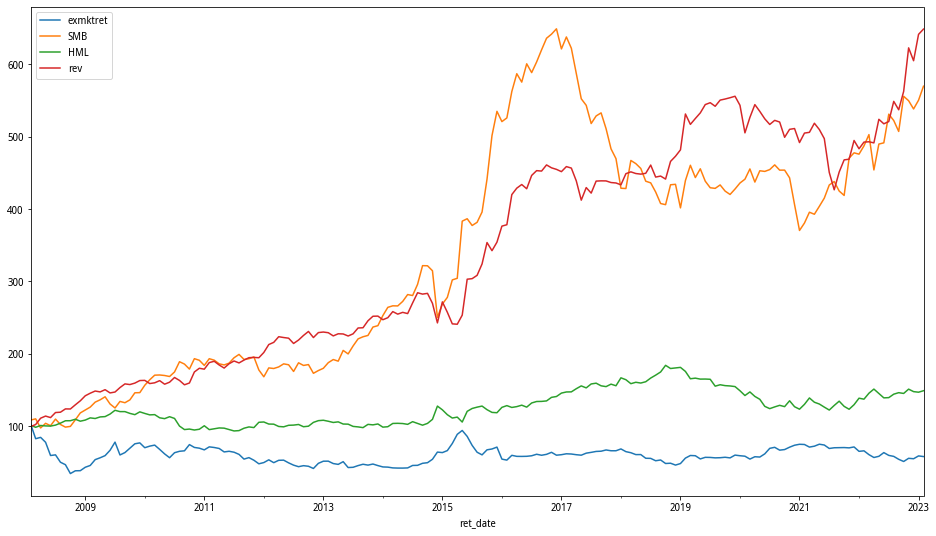

In [84]:
((1 + factors_df).cumprod()*100).plot()

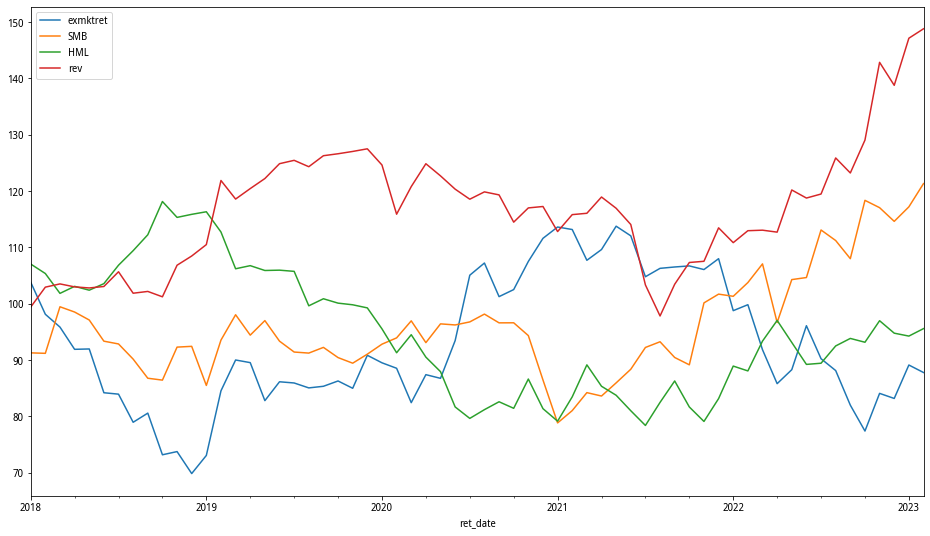

In [85]:
((1 + factors_df['2018':]).cumprod()*100).plot()

## Long-only factor

In [86]:
rev_long_df = (portfolios_vwret_df['Small_LowRet'] + portfolios_vwret_df['Big_LowRet']) / 2

rev_long_df = rev_long_df.reset_index()

rev_long_df.columns=['ret_date','rev_long']

rev_long_df

ret_date  rev_long
0    2008-02  0.061518
1    2008-03 -0.167375
2    2008-04  0.024523
3    2008-05 -0.041619
4    2008-06 -0.249352
5    2008-07  0.086448
6    2008-08 -0.203679
7    2008-09 -0.062323
..       ...       ...
174  2022-08 -0.010168
175  2022-09 -0.091581
176  2022-10  0.025716
177  2022-11  0.126171
178  2022-12 -0.043517
179  2023-01  0.097496
180  2023-02  0.020647
181  2023-03  0.001968

[182 rows x 2 columns]

In [87]:
factors_long_df = pd.read_csv('./output_data/factors/ff3_long_only.csv')

factors_long_df['ret_date'] = pd.to_datetime(factors_long_df['ret_date']) 

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_period('M')

factors_long_df = pd.merge(factors_long_df, rev_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

In [88]:
factors_long_df

exmktret  small_only  high_only  rev_long
ret_date                                             
2008-02-29  0.024010    0.103117   0.059319  0.061518
2008-03-31 -0.195480   -0.180562  -0.202495 -0.167375
2008-04-30  0.022519   -0.073326  -0.010688  0.024523
2008-05-31 -0.080798   -0.020022  -0.056407 -0.041619
2008-06-30 -0.236014   -0.257252  -0.239010 -0.249352
2008-07-31  0.014972    0.108774   0.072304  0.086448
2008-08-31 -0.170063   -0.232768  -0.187431 -0.203679
2008-09-30 -0.067913   -0.089285  -0.068049 -0.062323
...              ...         ...        ...       ...
2022-07-31 -0.060974    0.047271   0.002560  0.015416
2022-08-31 -0.023276   -0.034803  -0.009445 -0.010168
2022-09-30 -0.069642   -0.092335  -0.068136 -0.091581
2022-10-31 -0.056037    0.053699  -0.005541  0.025716
2022-11-30  0.086374    0.078566   0.103273  0.126171
2022-12-31 -0.010731   -0.041613  -0.040295 -0.043517
2023-01-31  0.071339    0.082598   0.065335  0.097496
2023-02-28 -0.014930    0.038597   0.020645  0.020647

[181 rows x 4 columns]

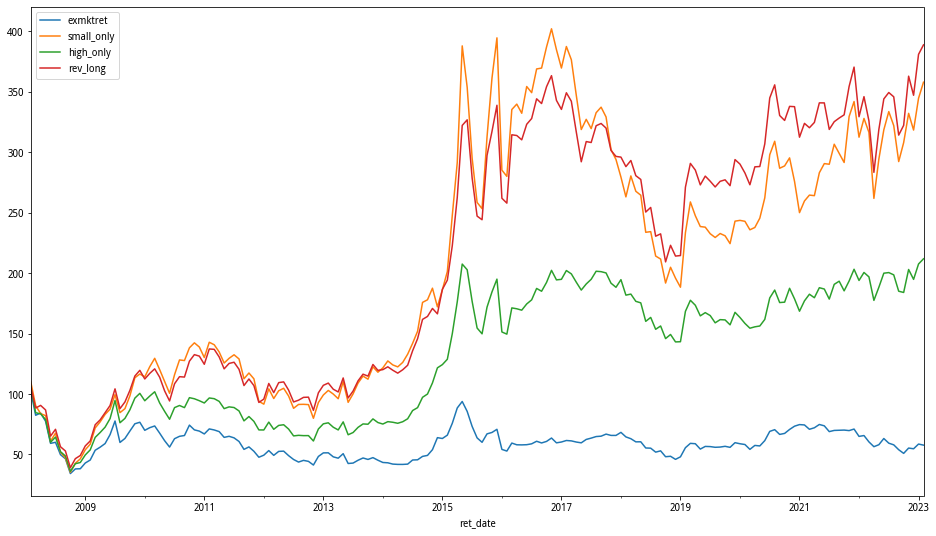

In [89]:
((1 + factors_long_df).cumprod()*100).plot()

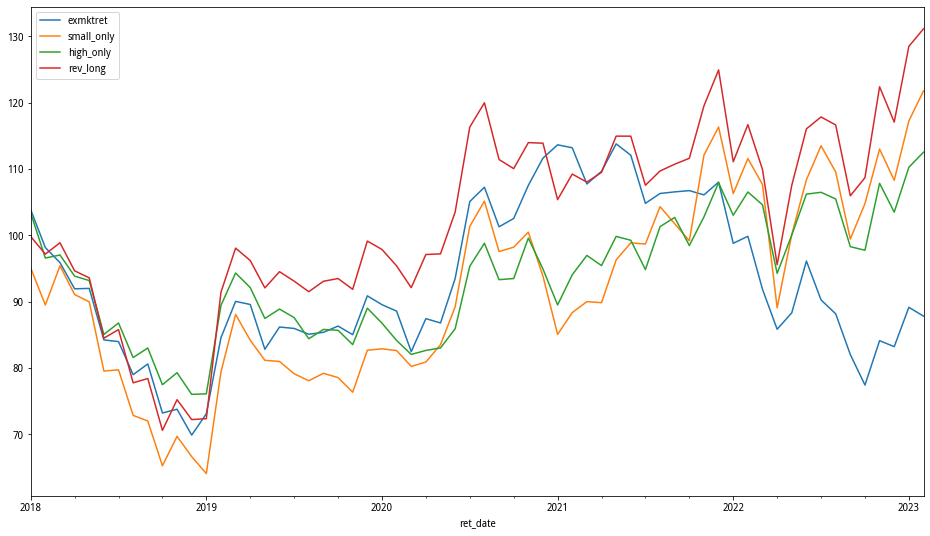

In [90]:
((1 + factors_long_df['2018':]).cumprod()*100).plot()

In [91]:
factors_long_df.to_csv('./output_data/factors/ff3_rev_long_only.csv')

In [92]:
factors_long_df.to_pickle('./output_data/factors/ff3_rev_long_only.pkl')